<a href="https://colab.research.google.com/github/soyoonjeong/computervision/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import numpy as np

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

# 데이터셋 불러오기

In [7]:
transform_data = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor()
    ])
training_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform_data
)
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform_data
)
train_dataloader = DataLoader(training_data, batch_size = 128, shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_data, batch_size = 128, shuffle = True, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# GAN 모델 정의

## 생성 모델 정의

In [8]:
latent_dim = 100
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        # 블록 1
        nn.Linear(latent_dim, 128),
        nn.LeakyReLU(0.2, inplace = True),
        # 블록 2
        nn.Linear(128, 256),
        nn.BatchNorm1d(256, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        # 블록 3
        nn.Linear(256, 512),
        nn.BatchNorm1d(512, 0.8),
        nn.LeakyReLU(0.2, inplace = True),
        # 블록 4
        nn.Linear(512, 1024),
        nn.BatchNorm1d(1024, 0.8),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Linear(1024, 1 * 28 * 28),
        nn.Tanh() # 왜 계속 Leaky Relu하다가 마지막만 tanh??
    )
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28) # 미니배치로 들어오나?
    return img

## 판별 모델 정의

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1*28*28, 512),
        nn.LeakyReLU(0.2, inplace = True), # inplace = True : 입력 텐서 직접 수정하여 연산 속도 높힘
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Linear(256, 1),
        nn.Sigmoid(), # 0~1 사이로 출력
    )
  def forward(self, img):
    flattened = img.view(img.size(0), -1)
    output = self.model(flattened)

    return output

# 훈련

In [10]:
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss() # 이진 크로스 엔트로피
adversarial_loss.cuda()

lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))

In [13]:
n_epochs = 200
n_iter_D = 1
sample_interval = 2000

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(train_dataloader):
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)
    real_imgs = imgs.cuda()

    # 판별 모델 훈련(n_iter_D번)
    for iter in range(n_iter_D):
      optimizer_D.zero_grad()

      z = torch.normal(mean = 0, std = 1, size= (imgs.shape[0], latent_dim)).cuda()
      generated_imgs = generator(z)

      real_loss = adversarial_loss(discriminator(real_imgs), real)
      fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
      d_loss = (real_loss + fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()

    # 생성 모델 훈련 (1번)
    optimizer_G.zero_grad()
    z = torch.normal(mean = 0, std = 1, size= (imgs.shape[0], latent_dim)).cuda()
    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    g_loss.backward()
    optimizer_G.step()

    #
    done = epoch * len(train_dataloader) + i
    if done % sample_interval == 0:
        save_image(generated_imgs.data[:25], f"{done}.png", nrow = 5, normalize = True)

  print(f"[Epoch {epoch}/{n_epochs}] [D_loss : {d_loss.item():.6f}] [G_loss : {g_loss.item():.6f}]")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[Epoch 0/200] [D_loss : 0.730373] [G_loss : 0.856183]
[Epoch 1/200] [D_loss : 0.650745] [G_loss : 1.269072]
[Epoch 2/200] [D_loss : 0.648036] [G_loss : 0.868366]
[Epoch 3/200] [D_loss : 0.648324] [G_loss : 0.831827]
[Epoch 4/200] [D_loss : 0.661978] [G_loss : 0.948425]
[Epoch 5/200] [D_loss : 0.643781] [G_loss : 0.879646]
[Epoch 6/200] [D_loss : 0.613606] [G_loss : 0.909540]
[Epoch 7/200] [D_loss : 0.611582] [G_loss : 0.895950]
[Epoch 8/200] [D_loss : 0.618647] [G_loss : 0.934059]
[Epoch 9/200] [D_loss : 0.627293] [G_loss : 0.932360]
[Epoch 10/200] [D_loss : 0.690554] [G_loss : 0.825459]
[Epoch 11/200] [D_loss : 0.603292] [G_loss : 1.114502]
[Epoch 12/200] [D_loss : 0.688361] [G_loss : 0.983554]
[Epoch 13/200] [D_loss : 0.670961] [G_loss : 1.028868]
[Epoch 14/200] [D_loss : 0.614244] [G_loss : 1.038047]
[Epoch 15/200] [D_loss : 0.607939] [G_loss : 1.118557]
[Epoch 16/200] [D_loss : 0.566023] [G_loss : 0.871614]
[Epoch 17/200] [D_loss : 0.576059] [G_loss : 1.105163]
[Epoch 18/200] [D_lo

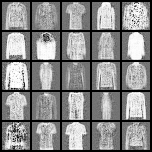

In [18]:
from IPython.display import Image

Image('92000.png')